In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import shutil

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
train_images = 'train/images'
train_masks = 'train/masks'
test_images = 'test/images'
test_masks = 'test/masks'

if not os.path.exists('train'):
    os.makedirs(train_images)
    os.makedirs(train_masks)
    
if not os.path.exists('test'):
    os.makedirs(test_images)
    os.makedirs(test_masks)

In [3]:
src_images = '/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/images'
src_masks = '/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/masks'

image_names = os.listdir(src_images)
mask_names = os.listdir(src_masks)

for img, mask in list(zip(image_names, mask_names))[:1000]:
    shutil.copyfile(os.path.join(src_images, img), os.path.join(train_images, img))
    shutil.copyfile(os.path.join(src_masks, mask), os.path.join(train_masks, mask))
    
for img, mask in list(zip(image_names, mask_names))[1000:]:
    shutil.copyfile(os.path.join(src_images, img), os.path.join(test_images, img))
    shutil.copyfile(os.path.join(src_masks, mask), os.path.join(test_masks, mask))

## Custom Encoder-Decoder

In [4]:
class Residual_Block(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.residual = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels)
        )
        
    def forward(self, x):
        return x + self.residual(x)

In [5]:
class Custom_Encoder_Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, residual_blocks):
        super().__init__()
        self.first = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True)
        )
        
        self.downsample = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        
        residual_layers = [Residual_Block(256) for num in range(residual_blocks)]
        self.residual = nn.Sequential(*residual_layers)
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.last = nn.Conv2d(64, out_channels, kernel_size=7, stride=1, padding=3)
    
    def forward(self, x):
        x = self.first(x)
        x = self.downsample(x)
        x = self.residual(x)
        x = self.upsample(x)
        return self.last(x)

## U-Net

In [6]:
class Double_Conv_2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Double_Conv_2d, self).__init__()
        # Two convolutions. Each convolution is followed by batch normalization, and the RELU activation function
        self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(out_channels),
                                  nn.ReLU(inplace=True),

                                  # Input channels will be the same as output channels from previous convolution
                                  nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(out_channels),
                                  nn.ReLU(inplace=True))
        
    def forward(self, x):
        return self.conv(x)

In [7]:
class U_Net(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(U_Net, self).__init__()
        
        # Number of filters in each section of the encoder, and the decoder
        features = [64, 128, 256, 512]

        # List of modules for the encoder
        self.downsample = nn.ModuleList()
        # List of modules for the decoder
        self.upsample = nn.ModuleList()
        # Variable to store max pooling function
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Adding Double Convolution modules to the encoder
        for i in features:
            self.downsample.append(Double_Conv_2d(in_channels, i))
            in_channels = i

        # Adding transpose convolution, and Double Convolution modules to the decoder
        for i in reversed(features):
            self.upsample.append(nn.ConvTranspose2d(i*2, i, kernel_size=2, stride=2))
            self.upsample.append(Double_Conv_2d(i*2, i))

        # Bottom most section of U-Net
        self.bottom = Double_Conv_2d(features[-1], features[-1]*2)

        # Final convolution on the last section of the decoder
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        # List to store skip connections
        skip_connections = []

        # Iterating over each section of the encoder
        for down in self.downsample:
            # Double Convolution
            x = down(x)
            # Add output to skip connections list
            skip_connections.append(x)
            # Max pooling
            x = self.pool(x)
        
        # Reverse the list of skip connections
        skip_connections = skip_connections[::-1]

        # Bottom most section of U-Net
        x = self.bottom(x)

        # List of transpose convolutions
        up_transpose = self.upsample[0::2]
        # List of Double Convolutions
        up_conv = self.upsample[1::2]

        # Iterating over each section of the decoder
        for i in range(len(self.upsample)//2):
            # Transpose convolution
            x = up_transpose[i](x)
            # Concatenating skip connection with output of transpose
            x = torch.cat((skip_connections[i], x), dim=1)
            # Double Convolution
            x = up_conv[i](x)

        # Final convolution on the last section of the decoder
        x = self.final_conv(x)
        return x

## Dataset Class

In [8]:
class SegmentationDataset(Dataset):
    def __init__(self, images_path, masks_path, transform):
        self.images_path = images_path
        self.masks_path = masks_path
        self.images = os.listdir(images_path)
        self.masks = os.listdir(masks_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_path, self.images[idx])
        img = Image.open(img_path).convert('RGB')
        
        mask_path = os.path.join(self.masks_path, self.masks[idx])
        mask = Image.open(mask_path).convert('L')
        
        return self.transform(img), self.transform(mask)

In [9]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

INPUT_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 20

TRAIN_IMAGES = 'train/images'
TRAIN_MASKS = 'train/masks'
TEST_IMAGES = 'test/images'
TEST_MASKS = 'test/masks'

TRANSFORM = transforms.Compose([transforms.Resize(INPUT_SIZE), transforms.ToTensor()])

In [10]:
train_dataset = SegmentationDataset(TRAIN_IMAGES, TRAIN_MASKS, TRANSFORM)
test_dataset = SegmentationDataset(TEST_IMAGES, TEST_MASKS, TRANSFORM)

In [11]:
train_loader = DataLoader(train_dataset, BATCH_SIZE)
test_loader = DataLoader(test_dataset, BATCH_SIZE)

## Training and Evaluating Function

In [12]:
def train_and_eval(epochs, model):
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_function = nn.BCEWithLogitsLoss()
    scaler = torch.cuda.amp.GradScaler()
    
    total_samples = len(test_loader.dataset)
    
    for epoch in range(epochs):
        # Training
        model.train()
        p_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        for images, masks in p_bar:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = loss_function(outputs, masks)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            p_bar.set_postfix({'Loss': loss.item()})

        # Evaluation
        model.eval()
        dice = 0
        with torch.no_grad():
            p_bar = tqdm(test_loader, desc=f'Epoch {epoch+1}')
            for images, masks in p_bar:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = torch.sigmoid(model(images))

                for mask, output in zip(masks, outputs):
                    prediction = (output > 0.5).float()
                    dice += 2 * (prediction * mask).sum() / (prediction + mask).sum()

        print(f'Mean Dice Score: {dice/total_samples}')

## Training and Evaluating Custom Encoder-Decoder

In [13]:
custom_model = Custom_Encoder_Decoder(3, 1, 9)
custom_model = nn.DataParallel(custom_model)
custom_model.to(DEVICE)
train_and_eval(EPOCHS, custom_model)

Epoch 1: 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]


Mean Dice Score: 0.0


Epoch 2: 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]


Mean Dice Score: 0.3402652144432068


Epoch 3: 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]


Mean Dice Score: 0.8870624303817749


Epoch 4: 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]


Mean Dice Score: 0.9085559844970703


Epoch 5: 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]


Mean Dice Score: 0.9146372079849243


Epoch 6: 100%|██████████| 6/6 [00:03<00:00,  1.92it/s]


Mean Dice Score: 0.7617686986923218


Epoch 7: 100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


Mean Dice Score: 0.9248260855674744


Epoch 8: 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]


Mean Dice Score: 0.9207178950309753


Epoch 9: 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]


Mean Dice Score: 0.9107892513275146


Epoch 10: 100%|██████████| 6/6 [00:03<00:00,  1.77it/s]


Mean Dice Score: 0.9236706495285034


Epoch 11: 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]


Mean Dice Score: 0.9312328696250916


Epoch 12: 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]


Mean Dice Score: 0.9335770010948181


Epoch 13: 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


Mean Dice Score: 0.935120701789856


Epoch 14: 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]


Mean Dice Score: 0.9359722137451172


Epoch 15: 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


Mean Dice Score: 0.9365150332450867


Epoch 16: 100%|██████████| 6/6 [00:03<00:00,  1.98it/s]


Mean Dice Score: 0.937049388885498


Epoch 17: 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]


Mean Dice Score: 0.9374068975448608


Epoch 18: 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]


Mean Dice Score: 0.9375540614128113


Epoch 19: 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Mean Dice Score: 0.9376111030578613


Epoch 20: 100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


Mean Dice Score: 0.9375542402267456


## Training and Evaluating U-Net

In [14]:
unet = U_Net(3, 1)
unet = nn.DataParallel(unet)
unet.to(DEVICE)
train_and_eval(EPOCHS, unet)

Epoch 1: 100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


Mean Dice Score: 0.1765245646238327


Epoch 2: 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]


Mean Dice Score: 0.8339213728904724


Epoch 3: 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Mean Dice Score: 0.9085683822631836


Epoch 4: 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]


Mean Dice Score: 0.9157046675682068


Epoch 5: 100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


Mean Dice Score: 0.9227270483970642


Epoch 6: 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Mean Dice Score: 0.9159983992576599


Epoch 7: 100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


Mean Dice Score: 0.9275487661361694


Epoch 8: 100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


Mean Dice Score: 0.9303094744682312


Epoch 9: 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Mean Dice Score: 0.9284355640411377


Epoch 10: 100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


Mean Dice Score: 0.926060676574707


Epoch 11: 100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


Mean Dice Score: 0.936126172542572


Epoch 12: 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]


Mean Dice Score: 0.9308909773826599


Epoch 13: 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]


Mean Dice Score: 0.9331032037734985


Epoch 14: 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]


Mean Dice Score: 0.933200478553772


Epoch 15: 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Mean Dice Score: 0.9347143173217773


Epoch 16: 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Mean Dice Score: 0.9356624484062195


Epoch 17: 100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


Mean Dice Score: 0.9343352317810059


Epoch 18: 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Mean Dice Score: 0.9352555274963379


Epoch 19: 100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


Mean Dice Score: 0.9349113702774048


Epoch 20: 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]


Mean Dice Score: 0.9377737045288086


## Setting Up Output Directory

In [15]:
save_dir = 'output'
save_path_custom = f'{save_dir}/custom_model'
save_path_unet = f'{save_dir}/u-net'

if not os.path.exists(save_dir):
    os.makedirs(save_path_custom)
    os.makedirs(save_path_unet)

## Function to Generate and Save Ouputs

In [16]:
def save_outputs(path, model):
    model.eval()
    i = 0
    
    with torch.no_grad():
        p_bar = tqdm(test_loader, desc='Saving Images')
        for images, masks in p_bar:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = torch.sigmoid(model(images))
            outputs[outputs > 0.5] = 255
            outputs[outputs <= 0.5] = 0

            for image, mask, output in zip(images, masks, outputs):
                save_image(image, os.path.join(path, f'{i}_0.png'))
                save_image(mask, os.path.join(path, f'{i}_1.png'))
                save_image(output, os.path.join(path, f'{i}_2.png'))

                i += 1

## Saving Outputs for Custom Encoder-Decoder

In [17]:
save_outputs(save_path_custom, custom_model)

Saving Images: 100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


## Saving Ouputs for U-Net

In [18]:
save_outputs(save_path_unet, unet)

Saving Images: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


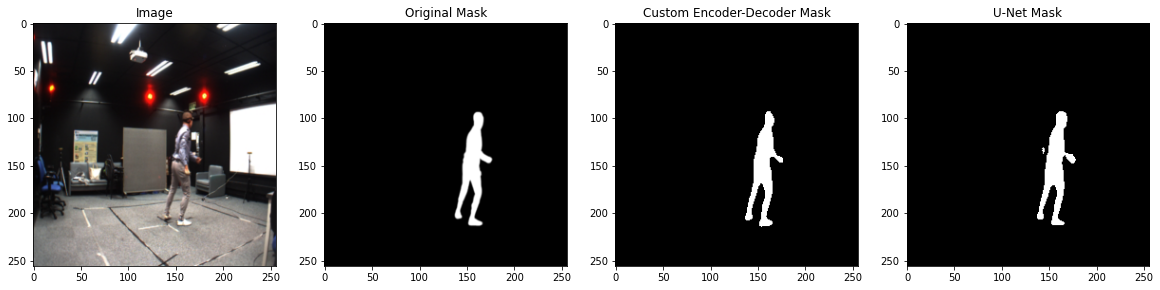

In [21]:
i = 1
image_custom = Image.open(os.path.join(save_path_custom, f'{i}_0.png')).convert('RGB')
mask_custom = Image.open(os.path.join(save_path_custom, f'{i}_1.png')).convert('L')
generated_custom = Image.open(os.path.join(save_path_custom, f'{i}_2.png')).convert('L')

generated_unet = Image.open(os.path.join(save_path_unet, f'{i}_2.png')).convert('L')

fig, ax = plt.subplots(1, 4, figsize=(20, 15))
ax[0].set_title('Image')
ax[0].imshow(image_custom)

ax[1].set_title('Original Mask')
ax[1].imshow(mask_custom, cmap='gray')

ax[2].set_title('Custom Encoder-Decoder Mask')
ax[2].imshow(generated_custom, cmap='gray')

ax[3].set_title('U-Net Mask')
ax[3].imshow(generated_unet, cmap='gray')

plt.show()